# **TIC-TOC**

This notebook is accompanying the Technical Note published in Biogeosciences: "Technical Note: A validated correction method to quantify
organic and inorganic carbon in soils using Rock-Eval® thermal
analysis". 

Feel free to contact the authors regarding any questions about its implementation and execution. 
Details about the data can be found in the ReadMe file and in the technical note. 


p.s. TIC-TOC is the internal name we used for this project, short for Total Inorganic Carbon-Total Organic Carbon.
In its final, published, version we replace Total with Soil (as it is more common in the community) and we talk about SIC and SOC. 

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set_theme(style='whitegrid')

random_seed = 10
random.seed(random_seed)
%matplotlib inline
%run -i setup/plots_settings.py

from functions.model_grid_search import *
from functions.error_and_plots import *

<Figure size 640x480 with 0 Axes>

In [49]:
all['Corrected_TIC_LR']

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
         ...    
235     0.000000
236     0.660646
237     0.000000
238     0.277675
239    13.681655
Name: Corrected_TIC_LR, Length: 240, dtype: float64

## Read all the data

In [50]:
re6_predictors = ['MINC', 'T10_HC_PYR', 'T30_HC_PYR', 'T50_HC_PYR', 'T70_HC_PYR',
       'T90_HC_PYR', 'T10_CO_PYR', 'T30_CO_PYR', 'T50_CO_PYR', 'T70_CO_PYR',
       'T90_CO_PYR', 'T10_CO2_PYR', 'T30_CO2_PYR', 'T50_CO2_PYR',
       'T70_CO2_PYR', 'T90_CO2_PYR', 'T10_CO_OX', 'T30_CO_OX', 'T50_CO_OX',
       'T70_CO_OX', 'T90_CO_OX', 'T10_CO2_OX', 'T30_CO2_OX', 'T50_CO2_OX',
       'T70_CO2_OX', 'T90_CO2_OX', 'S2', 'S2_PC', 'HI', 'OIre6', 'HI_OIre6', 'PC',
       'PC_TOCre6', 'TOCre6', 'TOC_istep', 'TOC_vt']

all = pd.read_csv('data/complete_dataset.csv')
re_info = pd.read_excel('data/TIC_TOC_DataR6_ISTeP_juin2023.xlsx', engine='openpyxl', sheet_name='TIC-TOC')
re_info['Sample'] = re_info['Sample'].replace({'SOIL_' : '', 'soil_' : '', 'Soil_' : ''}, regex=True)
re_info = re_info[re_info['Analysis'].str.contains('bis')==False]
      
only_carbonated = False
only_noncarbonated = False
TIC_carbonated_threshold = 2

if only_carbonated:
    all = all[all['TIC_istep'] > TIC_carbonated_threshold]

elif only_noncarbonated:
    all = all[all['TIC_istep'] <= TIC_carbonated_threshold]

all

Sample  TIC_las    TOC_las     N_las Analyse_istep  T10_HC_PYR_istep  \
0      9248     0.00   9.001205  1.022990     SOIL_9248             314.0   
1      9249     0.00   9.920865  1.147452     SOIL_9249             318.0   
2      9255     0.00   8.021192  0.833510     SOIL_9255             311.0   
3      9281     0.00   6.055106  0.580557     SOIL_9281             313.0   
4     10149     0.12  13.809574  1.451916    SOIL_10149             319.0   
..      ...      ...        ...       ...           ...               ...   
235     863     0.12   9.900807  0.902442      SOIL_863             314.0   
236     791     0.00  17.224451  1.208873      SOIL_791             317.0   
237    6925     0.12  11.800358  1.414970     SOIL_6925             322.0   
238    6961     0.00  14.513131  1.673007     SOIL_6961             321.0   
239    7010    13.56  15.151908  1.642092     SOIL_7010             340.0   

     T30_HC_PYR_istep  T50_HC_PYR_istep  T70_HC_PYR_istep  T90_HC_PYR_istep  \
0               374.0             417.0             460.0             525.0   
1               375.0             419.0             462.0             528.0   
2               370.0             415.0             458.0             524.0   
3               371.0             417.0             461.0             531.0   
4               374.0             418.0             459.0             513.0   
..                ...               ...               ...               ...   
235             375.0             420.0             466.0             541.0   
236             380.0             427.0             471.0             549.0   
237             378.0             422.0             464.0             528.0   
238             377.0             420.0             462.0             524.0   
239             397.0             440.0             481.0             538.0   

     ...  delta_tic_istep_vt  C_istep  delta_toc_las_istep  \
0    ...                -0.1     9.10             1.201205   
1    ...                -0.1     9.85             1.370865   
2    ...                 0.0     8.10             1.021192   
3    ...                 0.0     6.19             0.465106   
4    ...                 0.2    13.69             1.519574   
..   ...                 ...      ...                  ...   
235  ...                 0.0    10.11             1.090807   
236  ...                -0.2    17.41             2.014451   
237  ...                 0.2    11.71             1.590358   
238  ...                 0.1    14.10             2.213131   
239  ...                 0.0    28.95             2.001908   

     delta_tic_las_istep   C_vt  delta_toc_las_vt  delta_tic_las_vt  C_re7  \
0                  -1.30   9.31          1.091205             -1.40   8.46   
1                  -1.30  10.14          1.180865             -1.40   9.35   
2                  -1.10   8.20          0.921192             -1.10   7.79   
3                  -0.60   6.18          0.475106             -0.60   5.94   
4                  -1.28  13.46          1.549574             -1.08  13.34   
..                   ...    ...               ...               ...    ...   
235                -1.18   9.97          1.230807             -1.18   9.46   
236                -2.20  17.46          2.164451             -2.40  15.55   
237                -1.38  11.47          1.630358             -1.18  11.29   
238                -1.80  14.26          1.953131             -1.70  13.43   
239                -2.24  29.02          1.931908             -2.24  28.82   

     delta_toc_las_re7  delta_tic_las_re7  
0             1.341205              -0.80  
1             1.370865              -0.80  
2             0.931192              -0.70  
3             0.515106              -0.40  
4             1.469574              -0.88  
..                 ...                ...  
235           1.340807              -0.78  
236           3.374451              -1.70  
237           1.610358              -0.98  
238      

In [51]:
all['Sample'] = all['Sample'].astype('string')
all = pd.merge(left=all, right=re_info[['Sample', 'pyroMINC(%)', 'oxiMINC(%)', 'MINC(%)']], left_on='Sample', right_on='Sample')
all['oxiMinC'] = all['oxiMINC(%)'] * 10

## Compare SIC and SOC

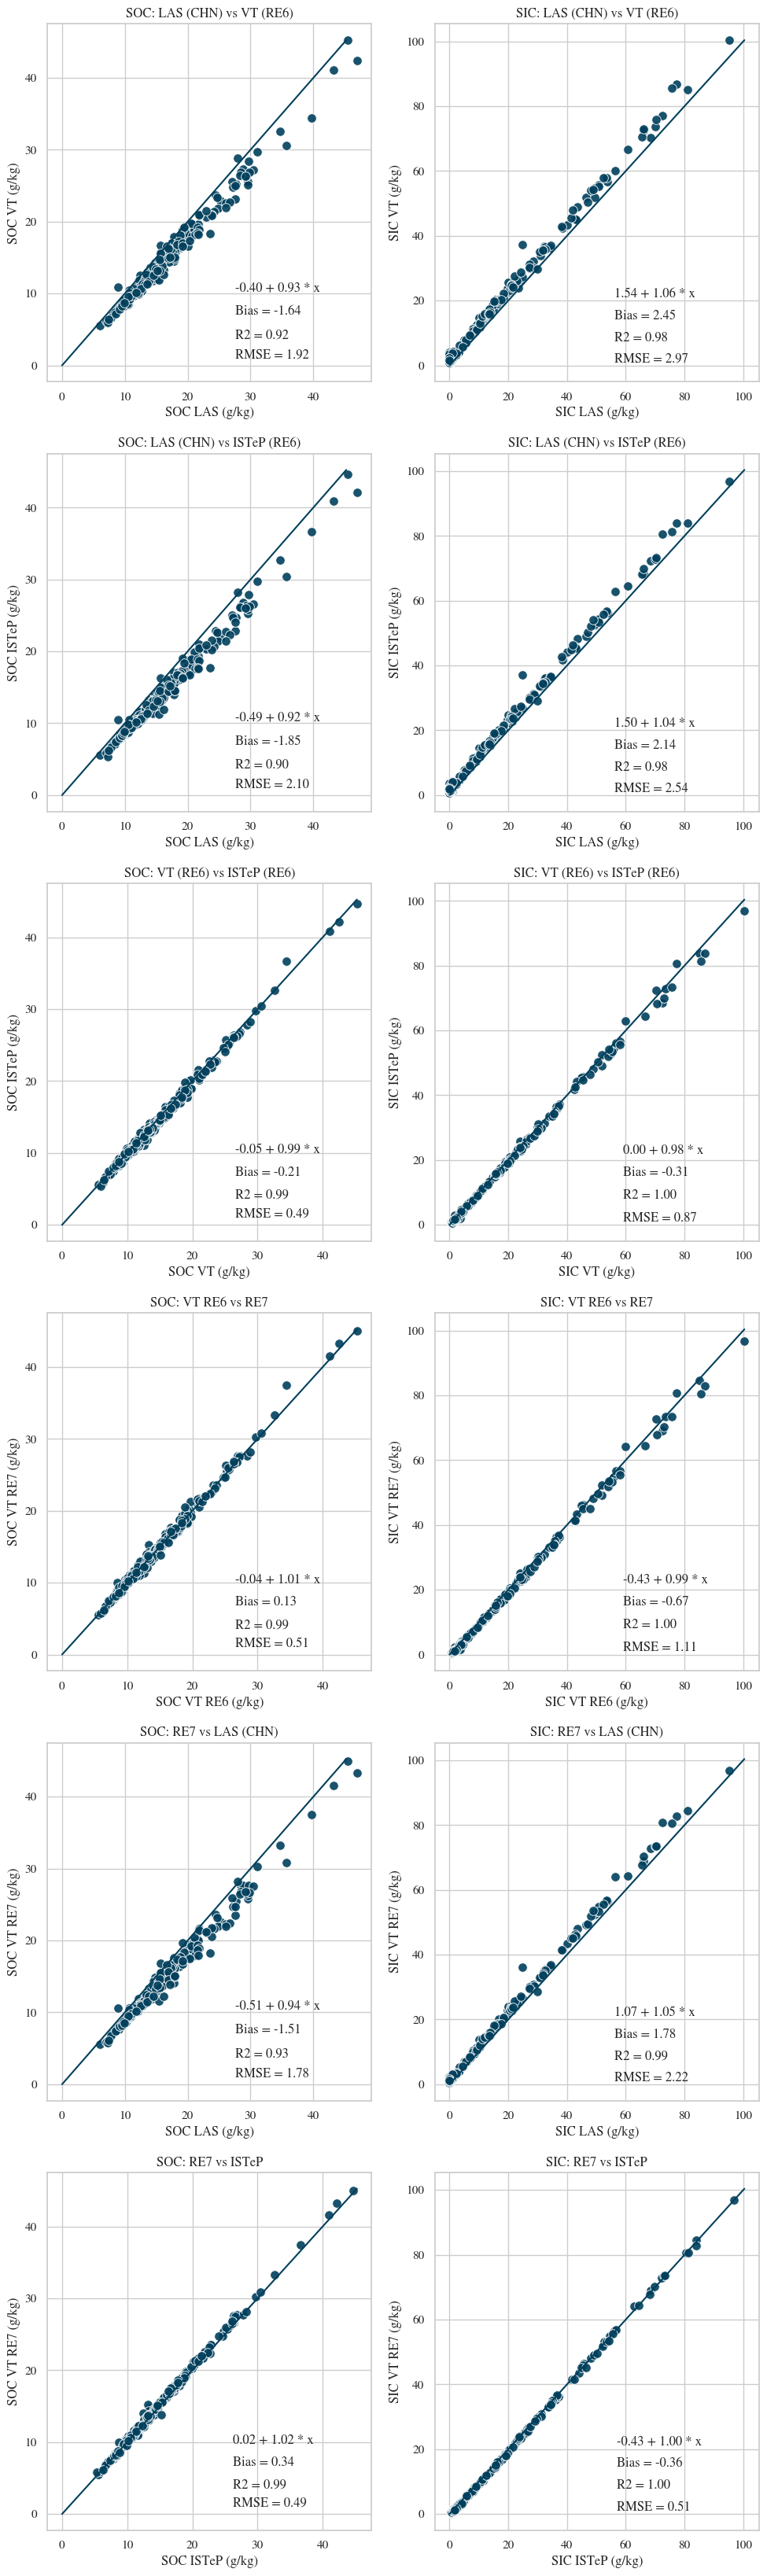

In [81]:
import warnings
warnings.filterwarnings("ignore")


plt.subplots(nrows=6, ncols=2, figsize=(10,33))

plt.subplot(6,2,1)
plt.title('SOC: LAS (CHN) vs VT (RE6)')
scatterplot_comparison(all, 'TOC_las', 'TOC_vt', )
sns.lineplot(x=[0,max(all['TOC_vt'])], y=[0,max(all['TOC_vt'])])
plt.xlabel('SOC LAS (g/kg)')
plt.ylabel('SOC VT (g/kg)')
plt.grid()
plt.subplot(6,2,2)
plt.title('SIC: LAS (CHN) vs VT (RE6)')
scatterplot_comparison(all, 'TIC_las', 'TIC_vt', )
sns.lineplot(x=[0,max(all['TIC_vt'])], y=[0,max(all['TIC_vt'])])
plt.grid()
plt.xlabel('SIC LAS (g/kg)')
plt.ylabel('SIC VT (g/kg)')

plt.subplot(6,2,3)
plt.title('SOC: LAS (CHN) vs ISTeP (RE6)')
scatterplot_comparison(all, 'TOC_las', 'TOC_istep', )
sns.lineplot(x=[0,max(all['TOC_vt'])], y=[0,max(all['TOC_vt'])])
plt.grid()
plt.xlabel('SOC LAS (g/kg)')
plt.ylabel('SOC ISTeP (g/kg)')
plt.subplot(6,2,4)
plt.title('SIC: LAS (CHN) vs ISTeP (RE6)')
scatterplot_comparison(all, 'TIC_las', 'TIC_istep', )
sns.lineplot(x=[0,max(all['TIC_vt'])], y=[0,max(all['TIC_vt'])])
plt.grid()
plt.xlabel('SIC LAS (g/kg)')
plt.ylabel('SIC ISTeP (g/kg)')

plt.subplot(6,2,5)
plt.title('SOC: VT (RE6) vs ISTeP (RE6)')
scatterplot_comparison(all, 'TOC_vt', 'TOC_istep', )
sns.lineplot(x=[0,max(all['TOC_vt'])], y=[0,max(all['TOC_vt'])])
plt.grid()
plt.xlabel('SOC VT (g/kg)')
plt.ylabel('SOC ISTeP (g/kg)')
plt.subplot(6,2,6)
plt.title('SIC: VT (RE6) vs ISTeP (RE6)')
scatterplot_comparison(all, 'TIC_vt', 'TIC_istep', )
sns.lineplot(x=[0,max(all['TIC_vt'])], y=[0,max(all['TIC_vt'])])
plt.grid()
plt.xlabel('SIC VT (g/kg)')
plt.ylabel('SIC ISTeP (g/kg)')
plt.tight_layout()

plt.subplot(6,2,7)
plt.title('SOC: VT RE6 vs RE7')
scatterplot_comparison(all, 'TOC_vt', 'TOC_re7', )
sns.lineplot(x=[0,max(all['TOC_vt'])], y=[0,max(all['TOC_vt'])])
plt.grid()
plt.xlabel('SOC VT RE6 (g/kg)')
plt.ylabel('SOC VT RE7 (g/kg)')
plt.subplot(6,2,8)
plt.title('SIC: VT RE6 vs RE7')
scatterplot_comparison(all, 'TIC_vt', 'TIC_re7', )
sns.lineplot(x=[0,max(all['TIC_vt'])], y=[0,max(all['TIC_vt'])])
plt.grid()
plt.xlabel('SIC VT RE6 (g/kg)')
plt.ylabel('SIC VT RE7 (g/kg)')

plt.subplot(6,2,9)
plt.title('SOC: RE7 vs LAS (CHN)')
scatterplot_comparison(all, 'TOC_las', 'TOC_re7', )
sns.lineplot(x=[0,max(all['TOC_vt'])], y=[0,max(all['TOC_vt'])])
plt.grid()
plt.xlabel('SOC LAS (g/kg)')
plt.ylabel('SOC VT RE7 (g/kg)')
plt.subplot(6,2,10)
plt.title('SIC: RE7 vs LAS (CHN)')
scatterplot_comparison(all, 'TIC_las', 'TIC_re7', )
sns.lineplot(x=[0,max(all['TIC_vt'])], y=[0,max(all['TIC_vt'])])
plt.grid()
plt.xlabel('SIC LAS (g/kg)')
plt.ylabel('SIC VT RE7 (g/kg)')
plt.tight_layout()
plt.savefig('output/figures_overleaf/meeting/comparisons.png', bbox_inches='tight')

plt.subplot(6,2,11)
plt.title('SOC: RE7 vs ISTeP')
scatterplot_comparison(all, 'TOC_istep', 'TOC_re7', )
sns.lineplot(x=[0,max(all['TOC_vt'])], y=[0,max(all['TOC_vt'])])
plt.grid()
plt.xlabel('SOC ISTeP (g/kg)')
plt.ylabel('SOC VT RE7 (g/kg)')
plt.subplot(6,2,12)
plt.title('SIC: RE7 vs ISTeP')
scatterplot_comparison(all, 'TIC_istep', 'TIC_re7', )
sns.lineplot(x=[0,max(all['TIC_vt'])], y=[0,max(all['TIC_vt'])])
plt.grid()
plt.xlabel('SIC ISTeP (g/kg)')
plt.ylabel('SIC VT RE7 (g/kg)')
plt.tight_layout()
plt.savefig('output/figures_overleaf/meeting/comparisons.png', bbox_inches='tight')

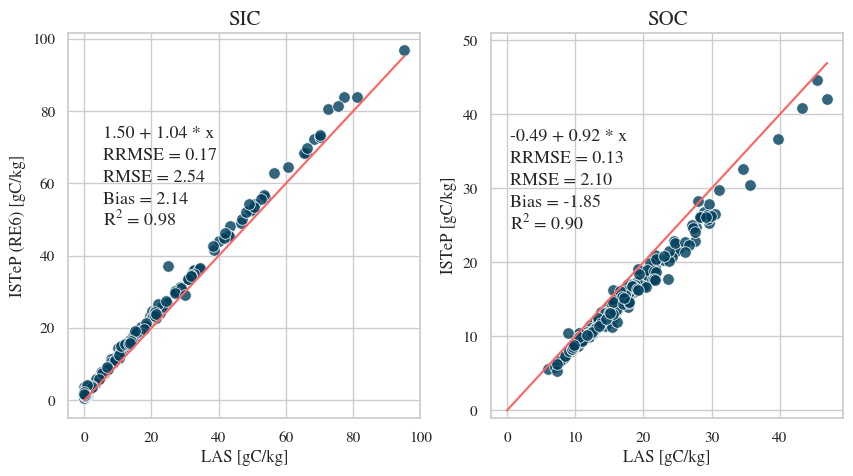

In [53]:
plt.subplots(nrows=1, ncols=2, figsize=(10,5))
from scipy import stats
plt.subplot(1,2,1)
plt.title('SIC', fontsize=15)
sns.scatterplot(data=all, x='TIC_las', y='TIC_istep', s=70, alpha=0.8)
sns.lineplot(x=[0,max(all['TIC_las'])], y=[0,max(all['TIC_las'])], color=color7d)
plt.grid(visible=True)
plt.xlabel('LAS [gC/kg]')
plt.ylabel('ISTeP (RE6) [gC/kg]')

fontsize = 13
slope, intercept, r, p, std_err = stats.linregress(x=all['TIC_las'], y=all['TIC_istep'])
rrmse = rrmse_function(y_true=all['TIC_las'], y_pred=all['TIC_istep'])
rmse = mean_squared_error(y_true=all['TIC_las'], y_pred=all['TIC_istep'], squared=False)
r2 = r2_score(y_true=all['TIC_las'], y_pred=all['TIC_istep'])
bias = bias_function(y_true=all['TIC_las'], y_pred=all['TIC_istep'])

plt.text(5.5, 72.5, '{:.2f} + {:.2f} * x'.format(intercept, slope), fontsize=fontsize)
plt.text(5.5, 66.5, 'RRMSE = {:.2f}'.format(rrmse), fontsize=fontsize)
plt.text(5.5, 60.5, 'RMSE = {:.2f}'.format(rmse), fontsize=fontsize)
plt.text(5.5, 54.5, 'Bias = {:.2f}'.format(bias), fontsize=fontsize)
plt.text(5.5, 48.5, 'R$^2$ = {:.2f}'.format(r2), fontsize=fontsize)


plt.subplot(1,2,2)
plt.title('SOC', fontsize=15)
sns.scatterplot(data=all, x='TOC_las', y='TOC_istep',  s=70, alpha=0.8)
sns.lineplot(x=[0,max(all['TOC_las'])], y=[0,max(all['TOC_las'])], color=color7d)
plt.xlabel('LAS [gC/kg]')
plt.ylabel('ISTeP [gC/kg]')
plt.grid(visible=True)

slope, intercept, r, p, std_err = stats.linregress(x=all['TOC_las'], y=all['TOC_istep'])
rrmse = rrmse_function(y_true=all['TOC_las'], y_pred=all['TOC_istep'])
rmse = mean_squared_error(y_true=all['TOC_las'], y_pred=all['TOC_istep'], squared=False)
r2 = r2_score(y_true=all['TOC_las'], y_pred=all['TOC_istep'])
bias = bias_function(y_true=all['TOC_las'], y_pred=all['TOC_istep'])

plt.ylim([-1, 51])
plt.text(0.5, 36.5, '{:.2f} + {:.2f} * x'.format(intercept, slope), fontsize=fontsize)
plt.text(0.5, 33.5, 'RRMSE = {:.2f}'.format(rrmse), fontsize=fontsize)
plt.text(0.5, 30.5, 'RMSE = {:.2f}'.format(rmse), fontsize=fontsize)
plt.text(0.5, 27.5, 'Bias = {:.2f}'.format(bias), fontsize=fontsize)
plt.text(0.5, 24.5, 'R$^2$ = {:.2f}'.format(r2), fontsize=fontsize)


plt.savefig('technical_note/figures/comparison_las_istep.png', bbox_inches='tight')

# Check the yield

Text(0.5, 0, 'Total C VT / Total C LAS (unitless)')

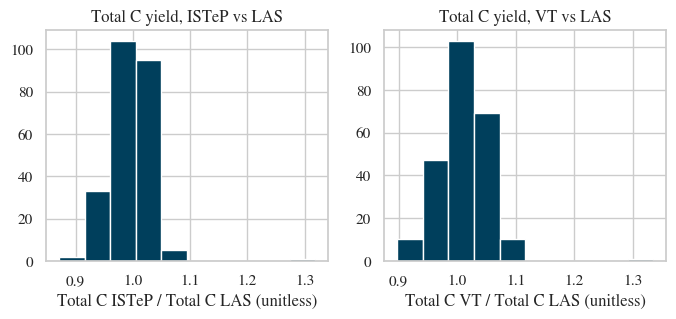

In [82]:
all['yield_istep_las'] = (all['TIC_istep'] + all['TOC_istep']) / (all['TIC_las'] + all['TOC_las'])
all['yield_vt_las'] = (all['TIC_vt'] + all['TOC_vt']) / (all['TIC_las'] + all['TOC_las'])

plt.subplots(nrows=1, ncols=2, figsize=(8,3))
plt.subplot(1,2,1)
all['yield_istep_las'].hist()
plt.title('Total C yield, ISTeP vs LAS')
plt.xlabel('Total C ISTeP / Total C LAS (unitless)')

plt.subplot(1,2,2)
all['yield_vt_las'].hist()
plt.title('Total C yield, VT vs LAS')
plt.xlabel('Total C VT / Total C LAS (unitless)')


## Dataset distributions

Text(0.5, 0, 'SOC class')

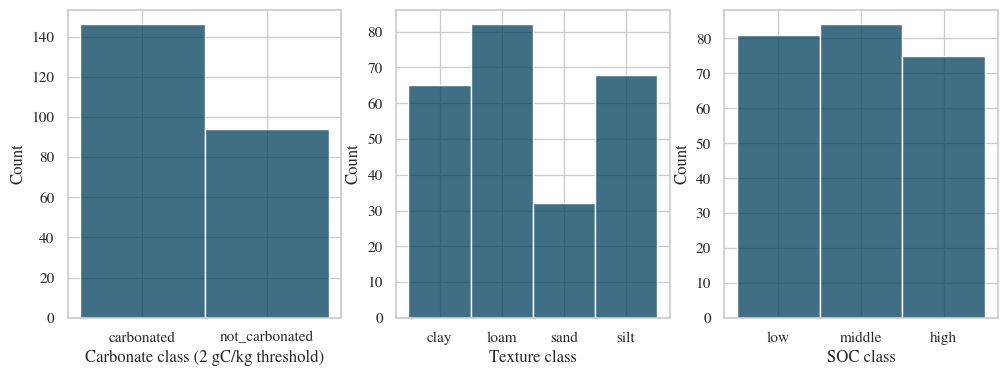

In [89]:
control = pd.read_excel('data/carbonates_class.xlsx', engine='openpyxl')
plt.subplots(ncols=3, nrows=1, figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(data=control, x='carbonate_class')
plt.xlabel('Carbonate class (2 gC/kg threshold)')
plt.subplot(1,3,2)
sns.histplot(data=control, x='broad_texture_class')
plt.xlabel('Texture class')
plt.subplot(1,3,3)
sns.histplot(data=control, x='toc_class')
plt.xlabel('SOC class')

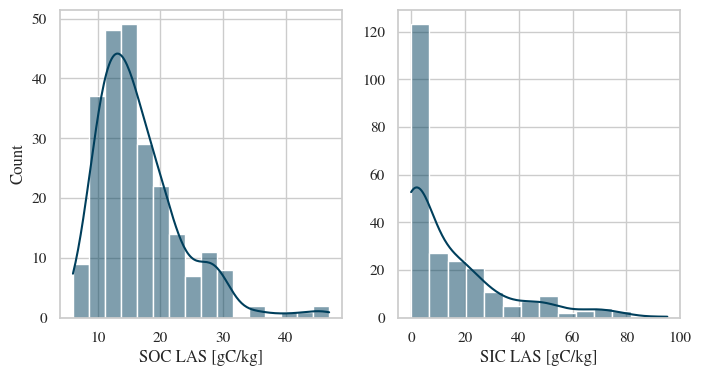

In [56]:
plt.subplots(ncols=2, nrows=1, figsize=(8,4))
plt.subplot(1,2,1)
sns.histplot(data=all, x='TOC_las', kde=True)
plt.xlabel('SOC LAS [gC/kg]')
plt.subplot(1,2,2)
sns.histplot(data=all, x='TIC_las', kde=True)
plt.xlabel('SIC LAS [gC/kg]')
plt.ylabel('')

plt.savefig('technical_note/figures/distribution_TIC_TOC.png', bbox_inches='tight', dpi=1000)

In [57]:
texture = pd.read_csv('data/texture.csv')
texture['Clay'] = texture['clay_sed']
texture['Sand'] = texture['sand_sed']
texture['Silt'] = texture['coarse_silt_sed'] + texture['fine_medium_silt_sed']
texture['Texture class'] = texture['texture_class']

texture = texture[texture['id'].isin(all['Sample'].values.astype(int))]


In [58]:
import plotly.express as px

fig = px.scatter_ternary(texture, a="Clay", b="Sand", c="Silt", size="TOC_CHN", 
                         labels={'color' : 'Texture class', 'symbol' : ''},
    color=texture['Texture class'].astype(str),
    symbol=texture['Texture class'].astype(str),
    color_discrete_map={'loamy_sand':color1d, 
                        'clay' : color2d,
                        'silty_clay_loam' : color7d,
                        'clay_loam' : color9dgray,
                        'silt_loam' : color5d,
                        'sandy_loam' : color3d,
                        'silty_clay' : color4d,
                        'loam' : color8dyellow,
                        'sandy_clay_loam' : color6d},
    width=1200, height=700, 
    opacity=0.8,
    # title='Cluster distribution based on texture. Point size is Corg (g/kg).'
    )

fig.update_layout(
    font_family="Times New Roman",
    font_color="black",
    font_size=30,
    title_font_family="Times New Roman",
    title_font_color="black",
    legend_title_font_color="black",
    legend_font_size=28,
    legend_font_family = "Times New Roman",
    legend_title='Texture class',
    legend= {'itemsizing': 'constant'}
)

fig.update_layout(
                                template='plotly_white',
                                # plot_bgcolor='rgba(0, 0, 0, 0)',
                                # paper_bgcolor='rgba(0, 0, 0, 0)',
                            )
fig.update_xaxes(showgrid=True, gridwidth=7, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

newnames = {'loamy_sand, loamy_sand': 'Loamy sand',
            'clay, clay': 'Clay',
            'silty_clay_loam, silty_clay_loam': 'Silty clay loam',
            'clay_loam, clay_loam': 'Clay loam',
            'silt_loam, silt_loam': 'Silt loam',
            'sandy_loam, sandy_loam': 'Sandy loam',
            'silty_clay, silty_clay': 'Silty clay',
            'loam, loam': 'Loam',
            'sandy_clay_loam, sandy_clay_loam': 'Sandy clay loam',
            }
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.75
))

fig.show()
# fig.write_image("technical_note/figures/texture.png")
# plt.savefig(os.path.join(figures_folder, 'texture_triangle_nclusters='+str(n_clusters_soil)+'_linkage='+ linkage+'.pdf'))

## Corrections

In [59]:
correlations_all = all.corr(method='spearman', numeric_only=True)

In [60]:
columns_to_drop=['PseudoS1',
                 'PseudoS1_vt',
                 'PseudoS1_istep',
                 'PseudoS1_re7', 
                 'TIC_las', 
                 'TOC_las', 
                 'TIC_merieux', 
                 'TOC_merieux', 
                 'TIC_vt', 
                 'TOC_vt', 
                 'Analyse', 
                 'Analysis',
                 'Analyse_istep',
                 'Analyse_vt',
                 'Prefix',
                 'Prefix_vt',
                 'Prefix_istep', 
                 'Sample',
                 'yield_istep_las',
                 'yield_istep_merieux',
                 'yield_vt_las',
                 'yield_vt_merieux',
                 'delta_toc_las_merieux',
                 'delta_tic_las_merieux',
                 'delta_c_las_merieux',
                 'delta_toc_istep_vt',
                 'delta_tic_istep_vt',
                 'C_istep',
                 'delta_toc_las_istep',
                 'delta_tic_las_istep',
                 'delta_toc_merieux_istep',
                 'delta_tic_merieux_istep',
                 'C_vt',
                 'delta_toc_las_vt',
                 'delta_tic_las_vt',
                 'delta_toc_merieux_vt',
                 'delta_tic_merieux_vt',
                 'C_re7',
                 'delta_toc_las_re7',
                 'delta_tic_las_re7',
                 'delta_toc_merieux_re7',
                 'delta_tic_merieux_re7',
                 'delta_toc_las_merieux',
                 'delta_tic_las_merieux',
                 'delta_c_las_merieux',
                 'C_las',
                 'C_merieux',
                 'CoverN_las',
                 'CoverN_merieux',
                 'C_re7']

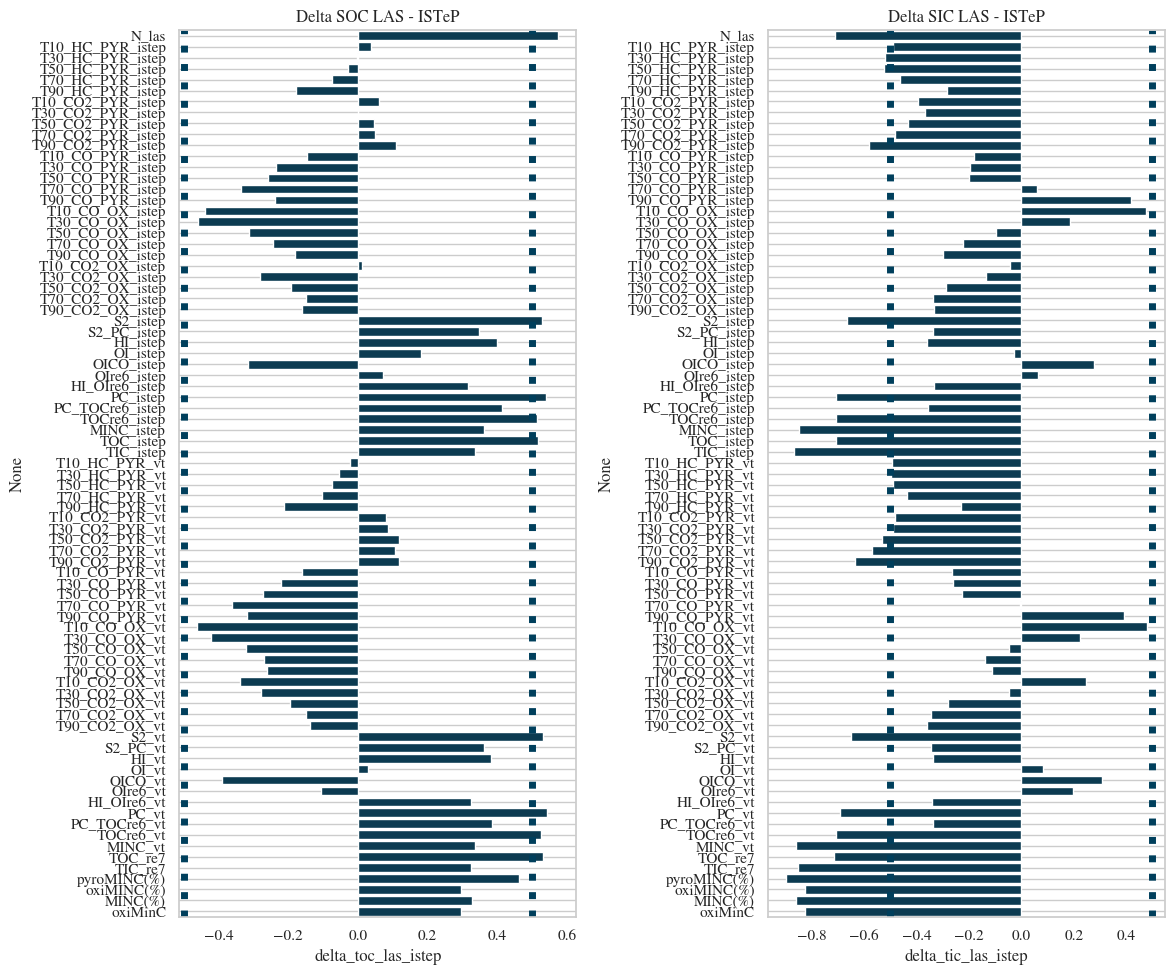

In [61]:
plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
plt.subplot(1,2,1)
sns.barplot(y=correlations_all['delta_toc_las_istep'].drop(columns_to_drop, errors='ignore').keys(), x=correlations_all['delta_toc_las_istep'].drop(columns_to_drop, errors='ignore'), orient='h')
plt.axvline(0.5, ls='dotted', lw=5)
plt.axvline(-0.5, ls='dotted', lw=5)
plt.title("Delta SOC LAS - ISTeP")
plt.grid()

plt.subplot(1,2,2)
sns.barplot(y=correlations_all['delta_tic_las_istep'].drop(columns_to_drop, errors='ignore').keys(), x=correlations_all['delta_tic_las_istep'].drop(columns_to_drop, errors='ignore'), orient='h')
plt.axvline(0.5, ls='dotted', lw=5)
plt.axvline(-0.5, ls='dotted', lw=5)
plt.title("Delta SIC LAS - ISTeP")
plt.grid()
plt.tight_layout()

## General correction function

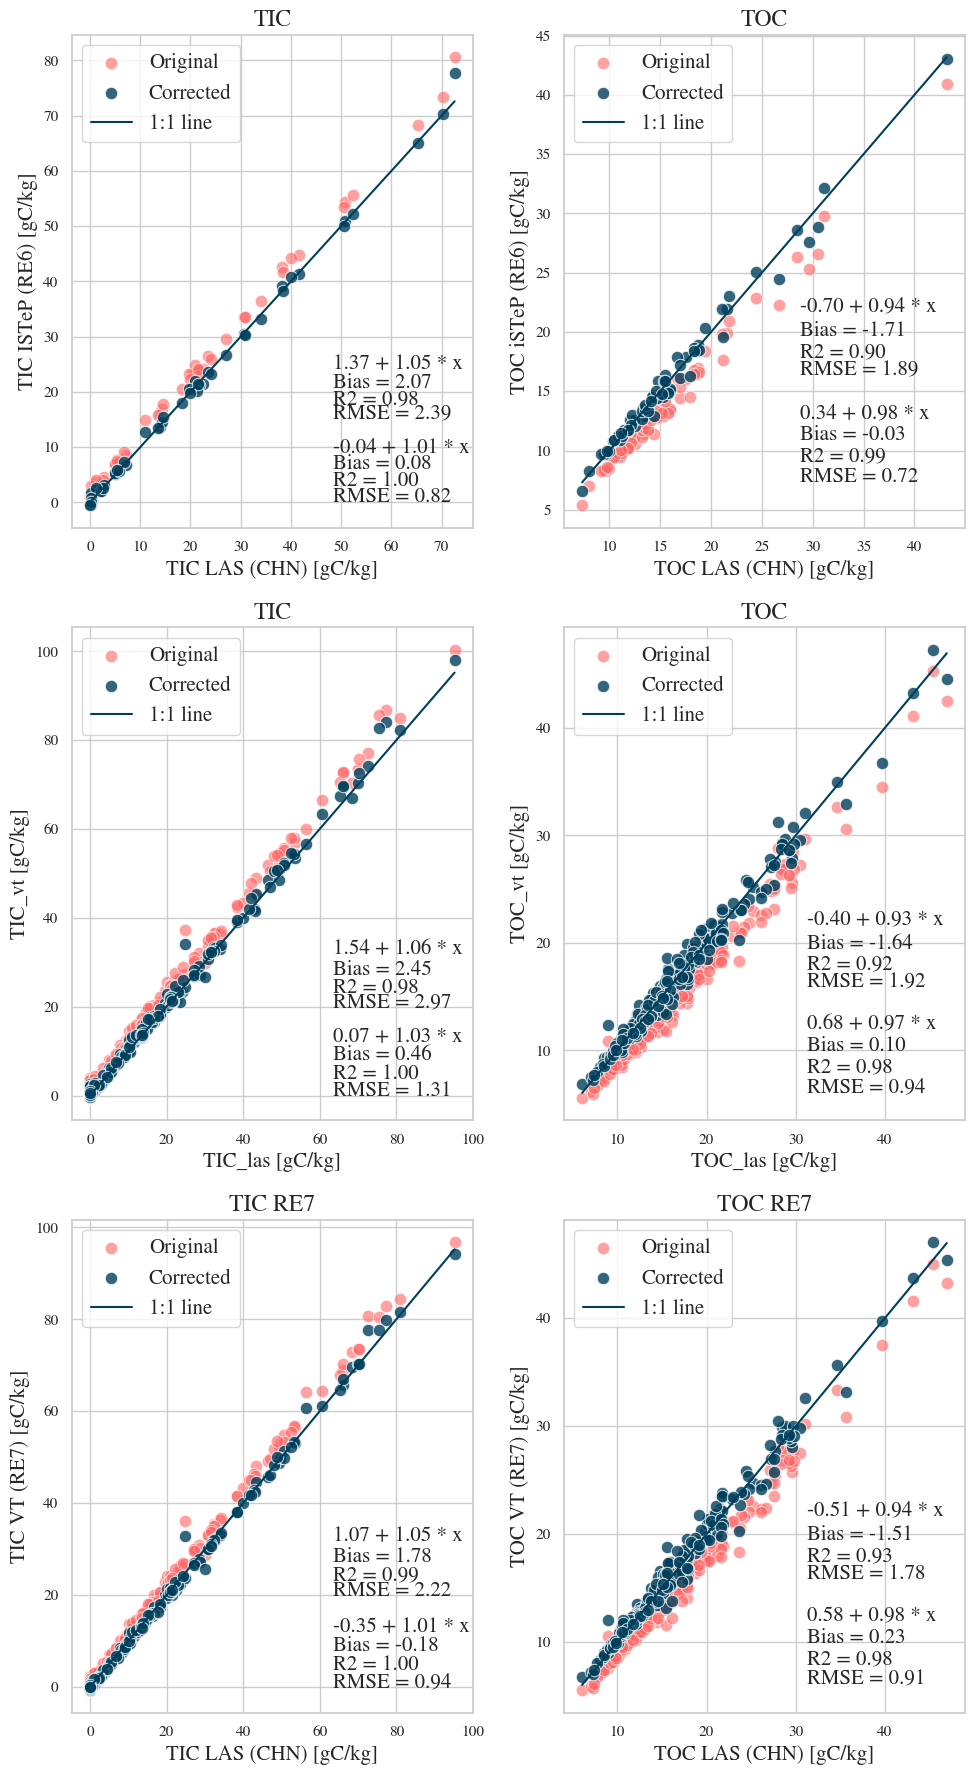

In [62]:
re6_origin='istep'
chn_origin='las'
model_name = 'SVM'
features='selected'
# features_tic = ['T90_CO2_PYR', 'T90_CO2_OX', 'T30_CO2_OX', 'TIC_'+re6_origin] # if you wanna test with more features (can be chosen based on the correlation figures)
# features_toc = ['TIC_'+re6_origin, 'PC_TOCre6', 'T90_CO_OX', 'TOC_'+re6_origin]
features_tic = ['TIC_'+re6_origin]
features_toc = ['TOC_'+re6_origin]

report=[]
report_columns = [
    'Model',
    'Target',
    'CHN_origin',
    'RE_origin',
    'Features',
    'CHN_target',
    'RE_target',
    'R2',
    'Bias',
    'RMSE',
    'RPIQ,',
    'Slope',
    'Intercept',
    'R2_corrected',
    'Bias_corrected',
    'RMSE_corrected',
    'RPIQ_corrected',
    'Slope_corrected',
    'Intercept_corrected',
]
report, regressor_toc, regressor_tic, train_index, test_index = run_full_model(data=all,
                                                                               re6_predictors=re6_predictors,
                                                                               re6_origin=re6_origin, 
                                                                               chn_origin=chn_origin, 
                                                                               model_name=model_name, 
                                                                               features=features, 
                                                                               features_tic=features_tic,
                                                                               features_toc=features_toc,
                                                                               report=report, 
                                                                               only_carbonated=only_carbonated, 
                                                                               only_noncarbonated=only_noncarbonated)

In [63]:
# if you want to run all combinations 
re6_origin='istep'
chn_origin='las'
model_name = 'SVM'
features='selected'
TIC_carbonated_threshold = 2
features_tic = ['TIC_'+re6_origin]
features_toc = ['TOC_'+re6_origin]

regressors_tic = {}
regressors_toc = {}

report=[]
report_columns = [
    'Model',
    'Target',
    'CHN_origin',
    'RE_origin',
    'Features',
    'CHN_target',
    'RE_target',
    'R2',
    'Bias',
    'RMSE',
    'RPIQ,',
    'Slope',
    'Intercept',
    'R2_corrected',
    'Bias_corrected',
    'RMSE_corrected',
    'RPIQ_corrected',
    'Slope_corrected',
    'Intercept_corrected',
]

for re6_origin in ['istep']:#, 'vt']:
    for chn_origin in ['las']:
        for model_name in ['SVM', 'RF', 'LR', 'Ridge']:
            for features in ['selected']:#, 'all]
                report, regressors_toc[model_name], regressors_tic[model_name], train_index, test_index = run_full_model(data=all,
                                                                                                      re6_predictors=re6_predictors,
                                                                                                      re6_origin=re6_origin, 
                                                                                                      chn_origin=chn_origin, 
                                                                                                      model_name=model_name, 
                                                                                                      features=features, 
                                                                                                      report=report, 
                                                                                                      only_carbonated=only_carbonated, 
                                                                                                      only_noncarbonated=only_noncarbonated,
                                                                                                      TIC_carbonated_threshold= TIC_carbonated_threshold)
                plt.close()

final_report = pd.DataFrame(report, columns=report_columns).round(4)


#### Comparing the distributions of the test and train data

We make sure that there are no big discrepancies between the two data sets used for testing and training. 

In [16]:
train_data = all.iloc[train_index]
test_data = all.iloc[test_index]

<Axes: xlabel='TOC_istep', ylabel='Density'>

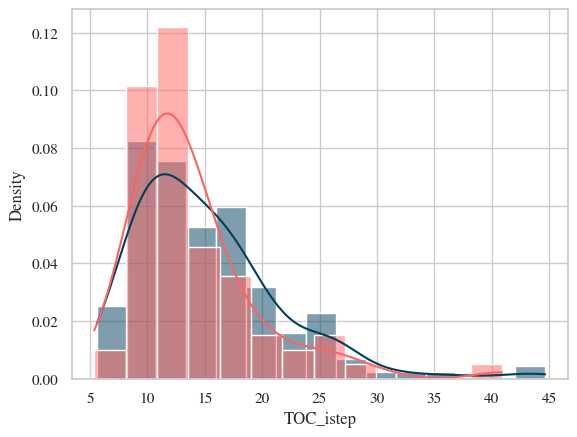

In [17]:
sns.histplot(data=train_data, x='TOC_istep', stat='density', kde=True, label='Train')
sns.histplot(data=test_data, x='TOC_istep', stat='density', kde=True, label='Test')

<Axes: xlabel='TIC_istep', ylabel='Density'>

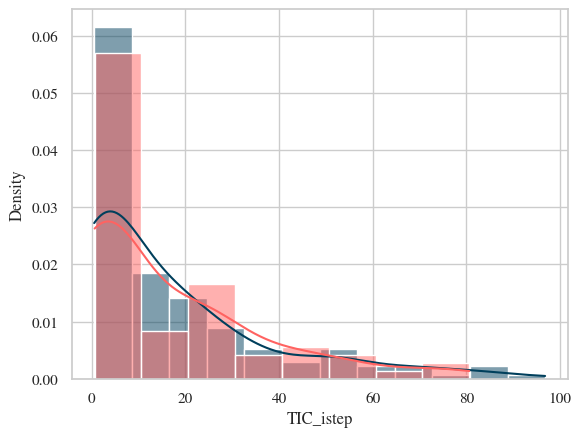

In [18]:
sns.histplot(data=train_data, x='TIC_istep', stat='density', kde=True, label='Train')
sns.histplot(data=test_data, x='TIC_istep', stat='density', kde=True, label='Test')

## Hazera correction 

Taken from [here](https://bg.copernicus.org/articles/20/5229/2023/bg-20-5229-2023.pdf):

If carbonated and enriched in poorly degraded organic compounds and
litter debris:
- TOC_corrected = 1.17 \* TOCre6
- TIC_corrected = MINC - 0.092\*TOCre6

If non-carbonated and enriched in poorly degraded organic compounds and
litter debris:
- TOC_corrected = (TOC + MINC) * 1.068
- MINC_corrected = 0

The article does not provide a definition of non-carbonated and only 4 samples are considered as such. 
They all have a TIC < 2gC/kg so we will use that threshold. 

In [35]:
def hazera_correction(data:pd.DataFrame, re6_source:str, noncarbonated_threshold_Hazera:float=2, noncarbonated_targed = 'TIC', topsoil=True):
    # the mask containts the list of non-carbonated soils
    # we consider a sample to be carbonated if TIC > 2g/kg (if noncarbonated_carget == 'TIC')
    # or if OxiMinX > 1 g/kg (if noncarbonated_carget != 'TIC')
    if noncarbonated_targed == 'TIC' :
        mask = (data['TIC_'+re6_source] <= noncarbonated_threshold_Hazera)
    else:
        mask = (data['oxiMinC'] <= noncarbonated_threshold_Hazera)

    # if topsoil, we add the PDOM correction proposed in Hazera (extra 6.8% of SOC)
    if topsoil:
        data['tic_correction_Hazera_'+re6_source] = - 0.092 * data['TOC_'+re6_source]
        data.loc[mask, 'tic_correction_Hazera_'+re6_source] = - data['TIC_'+re6_source]

        data['toc_correction_Hazera_'+re6_source] = + 0.17 * data['TOC_'+re6_source]
        data.loc[mask, 'toc_correction_Hazera_'+re6_source] = + data['TOC_'+re6_source] * 0.068 + data['TIC_'+re6_source] * 1.068

    else:
        data['tic_correction_Hazera_'+re6_source] = - 0.092 * data['TOC_'+re6_source]
        data.loc[mask, 'tic_correction_Hazera_'+re6_source] = - data['TIC_'+re6_source]

        data['toc_correction_Hazera_'+re6_source] = + 0.092 * data['TOC_'+re6_source]
        data.loc[mask, 'toc_correction_Hazera_'+re6_source] = data['TIC_'+re6_source]

    return data


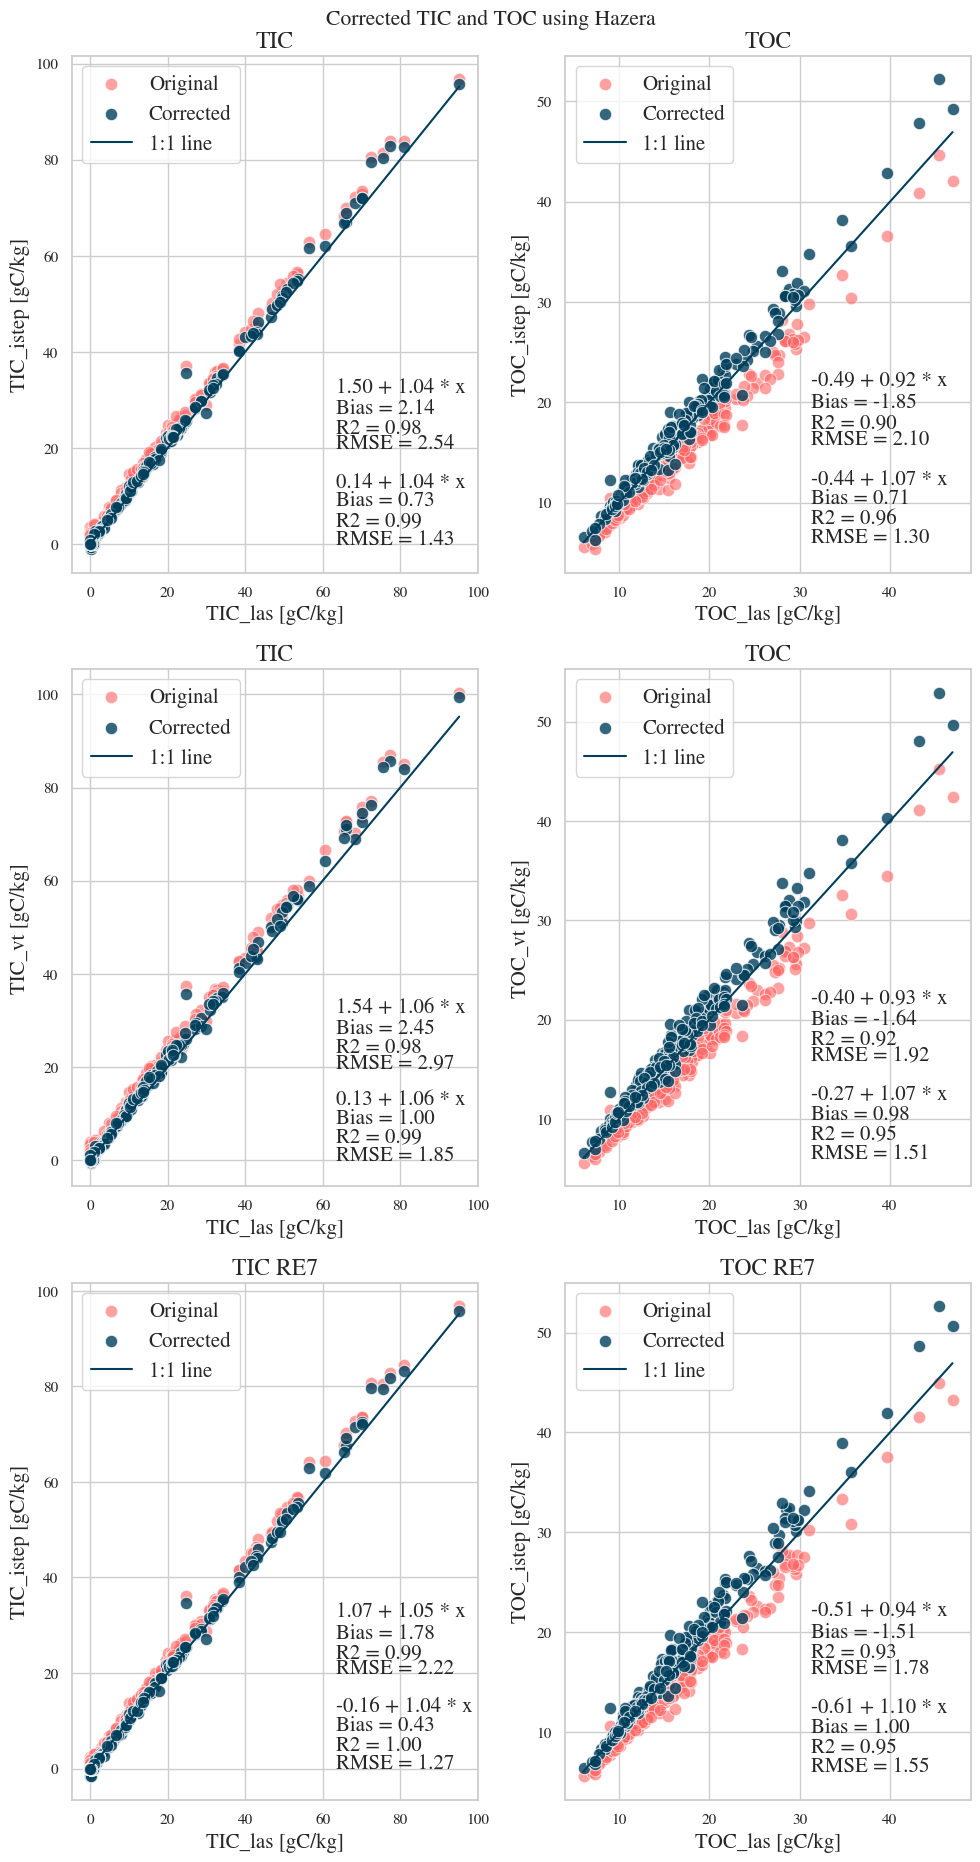

In [22]:
re6_origin='istep'
chn_origin='las'
model_name = 'Hazera'
features='selected'
noncarbonated_threshold_Hazera = 2
data_type = '_' + only_carbonated*'only_carbonated' + only_noncarbonated*'only_noncarbonated'

all_vt = all.loc[:,(~all.columns.str.contains('_istep', case=False)&(~all.columns.str.contains('_re7', case=False)))].copy()
all_istep = all.loc[:,(~all.columns.str.contains('_re7', case=False)&(~all.columns.str.contains('_vt', case=False)))].copy()
all_re7 = all.loc[:,(~all.columns.str.contains('_istep', case=False)&(~all.columns.str.contains('_vt', case=False)))].copy()


all_istep = hazera_correction(all_istep, 'istep')
all_vt = hazera_correction(all_vt, 'vt')
all_re7 = hazera_correction(all_re7, 're7')

plt.subplots(3, 2, figsize=(10,19))
plt.suptitle('Corrected TIC and TOC using Hazera')
# LAS ISTEP
plt.subplot(3,2,1)
y_chn_las_istep = all_istep['TIC_las']
y_re_las_istep = all_istep['TIC_istep']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_las_istep, y=y_re_las_istep, correction=all_istep['tic_correction_Hazera_istep'], xlabel='TIC_las', ylabel='TIC_istep', name='TIC')
plt.grid()

plt.subplot(3,2,2)
y_chn_las_istep = all_istep['TOC_las']
y_re_las_istep = all_istep['TOC_istep']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_las_istep, y=y_re_las_istep, correction=all_istep['toc_correction_Hazera_istep'], xlabel='TOC_las', ylabel='TOC_istep', name='TOC')
plt.grid()

# LAS vt
plt.subplot(3,2,3)
y_chn_las_vt = all_vt['TIC'+'_las']
y_re_las_vt = all_vt['TIC_vt']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_las_vt, y=y_re_las_vt, correction=all_vt['tic_correction_Hazera_vt'], xlabel='TIC_las', ylabel='TIC_vt', name='TIC')
plt.grid()

plt.subplot(3,2,4)
y_chn_las_vt = all_vt['TOC'+'_las']
y_re_las_vt = all_vt['TOC_vt']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_las_vt, y=y_re_las_vt, correction=all_vt['toc_correction_Hazera_vt'], xlabel='TOC_las', ylabel='TOC_vt', name='TOC')
plt.grid()

# RE7
plt.subplot(3,2,5)
y_chn_re7_las_istep = all_re7['TIC'+'_las']
y_re_re7_las_istep = all_re7['TIC_re7']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_re7_las_istep, y=y_re_re7_las_istep, correction=all_re7['tic_correction_Hazera_re7'], xlabel='TIC_las', ylabel='TIC_istep', name='TIC RE7')
plt.grid()

plt.subplot(3,2,6)
y_chn_re7_las_istep = all_re7['TOC'+'_las']
y_re_re7_las_istep = all_re7['TOC_re7']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_re7_las_istep.astype(float), y=y_re_re7_las_istep.astype(float), correction=all_re7['toc_correction_Hazera_re7'], xlabel='TOC_las', ylabel='TOC_istep', name='TOC RE7')
plt.grid()

plt.tight_layout()
plt.savefig('output/corrections/'+model_name+'/'+chn_origin + '_' + re6_origin + '_features=' + str(features)+  data_type + '.png', bbox_inches='tight')


### Save corrections from all models 

In [23]:
for model_name in ['SVM', 'RF', 'LR', 'Ridge']:
    all['Corrected_TOC_' + model_name] = all['TOC_istep'] + regressors_toc[model_name].predict(all[['TOC_istep']])
    all['Corrected_TIC_' + model_name] = all['TIC_istep'] + regressors_tic[model_name].predict(all[['TIC_istep']])
    all['Corrected_TIC_' + model_name] = all['Corrected_TIC_' + model_name].clip(0, None)
all = hazera_correction(data=all, re6_source='istep')    
all['tic_correction_Hazera_istep'] = all['tic_correction_Hazera_istep'] + all['TIC_istep']
all['toc_correction_Hazera_istep'] = all['toc_correction_Hazera_istep'] + all['TOC_istep']
all.rename(columns={'tic_correction_Hazera_istep' : 'Corrected_TIC_Hazera_with_PDOM_TIC', 'toc_correction_Hazera_istep' : 'Corrected_TOC_Hazera_with_PDOM_TIC'}, inplace=True)


In [28]:
# all.to_csv('output/complete_corrections.csv')

# Supplementary material

## Comparing models

In [ ]:
re6_origin='istep'
chn_origin='las'
model_name = 'SVM'
features='selected'
only_noncarbonated=False
only_carbonated=False
TIC_carbonated_threshold = 2
features_tic = ['TIC_'+re6_origin]
features_toc = ['TOC_'+re6_origin]

regressors_tic_supplementary = {}
regressors_toc_supplementary = {}

for model_name in ['SVM', 'RF', 'LR', 'Ridge']:
    _, regressors_toc_supplementary[model_name], regressors_tic_supplementary[model_name], _, _ = run_full_model(data=all,
                                                                                                                 re6_predictors=re6_predictors,
                                                                                                                 re6_origin=re6_origin, 
                                                                                                                 chn_origin=chn_origin, 
                                                                                                                 model_name=model_name, 
                                                                                                                 features=features, 
                                                                                                                 report=report, 
                                                                                                                 only_carbonated=only_carbonated, 
                                                                                                                 only_noncarbonated=only_noncarbonated,
                                                                                                                 TIC_carbonated_threshold= TIC_carbonated_threshold)
    plt.close()

#### Partial dependence plots

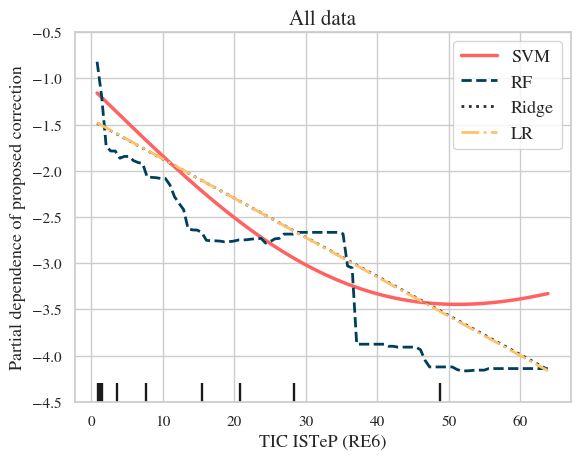

In [18]:
from sklearn.inspection import PartialDependenceDisplay

disp1 = PartialDependenceDisplay.from_estimator(regressors_tic_supplementary['SVM'], 
                                                all[['TIC_istep']], 
                                                features=['TIC_istep'], 
                                                line_kw={"linewidth": 2.5, "label": "SVM", "color": color7d},)
disp2 = PartialDependenceDisplay.from_estimator(regressors_tic_supplementary['RF'], 
                                                all[['TIC_istep']], 
                                                features=['TIC_istep'],
                                                ax=disp1.axes_ ,
                                                line_kw={"linewidth": 2, "label": "RF", "color": color1d, 'linestyle':'--'},)
disp3 = PartialDependenceDisplay.from_estimator(regressors_tic_supplementary['Ridge'], 
                                                all[['TIC_istep']], 
                                                features=['TIC_istep'], 
                                                ax=disp1.axes_, 
                                                line_kw={"linewidth": 2, "label": "Ridge", "color": color9dgray, 'linestyle':':'})
disp4 = PartialDependenceDisplay.from_estimator(regressors_tic_supplementary['LR'], 
                                                all[['TIC_istep']], 
                                                features=['TIC_istep'], 
                                                ax=disp1.axes_,
                                                line_kw={"linewidth": 2, "label": "LR", "color": color8dyellow, 'linestyle':'-.'},)
plt.ylim([-4.5, -0.5])
plt.xlabel('TIC ISTeP (RE6)', fontsize=13)
plt.ylabel('Partial dependence of proposed correction', fontsize=13)
plt.title('All data', fontsize=15)
plt.legend(fontsize=13)
plt.savefig('technical_note/figures/all_data_pdp_tic.png', bbox_inches='tight')
                                                

<Axes: xlabel='TIC_las', ylabel='TOC_las'>

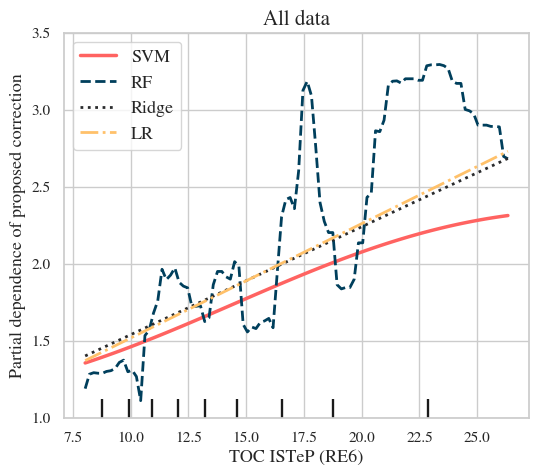

In [21]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,5))
disp1 = PartialDependenceDisplay.from_estimator(regressors_toc_supplementary['SVM'], 
                                                all[['TOC_istep']], 
                                                features=['TOC_istep'], 
                                                line_kw={"linewidth": 2.5, "label": "SVM", "color": color7d},
                                                ax=ax1)
disp2 = PartialDependenceDisplay.from_estimator(regressors_toc_supplementary['RF'], 
                                                all[['TOC_istep']], 
                                                features=['TOC_istep'],
                                                ax=disp1.axes_ ,
                                                line_kw={"linewidth": 2, "label": "RF", "color": color1d, 'linestyle':'--'},)
disp3 = PartialDependenceDisplay.from_estimator(regressors_toc_supplementary['Ridge'], 
                                                all[['TOC_istep']], 
                                                features=['TOC_istep'], 
                                                ax=disp1.axes_, 
                                                line_kw={"linewidth": 2, "label": "Ridge", "color": color9dgray, 'linestyle':':'},)
disp4 = PartialDependenceDisplay.from_estimator(regressors_toc_supplementary['LR'], 
                                                all[['TOC_istep']], 
                                                features=['TOC_istep'], 
                                                ax=disp1.axes_,
                                                line_kw={"linewidth": 2, "label": "LR", "color": color8dyellow, 'linestyle':'-.'},)

plt.ylim([1.0, 3.5])
plt.xlabel('TOC ISTeP (RE6)', fontsize=13)
plt.ylabel('Partial dependence of proposed correction', fontsize=13)
plt.title('All data', fontsize=15)
plt.legend(fontsize=13)

sns.scatterplot(data=all, x='TIC_las', y='TOC_las',ax=ax1)

#### Paired T-tess

In [84]:
all = pd.read_csv('output/complete_corrections.csv')
import scipy.stats as stats 
print(stats.ttest_rel(all['Corrected_TIC_Hazera_with_PDOM_OxiMinC'] - all['TIC_istep'], all['Corrected_TIC_SVM']  - all['TIC_istep'] ))
print(stats.ttest_rel(all['Corrected_TOC_Hazera_with_PDOM_OxiMinC'] - all['TOC_istep'], all['Corrected_TOC_SVM']  - all['TOC_istep'] ))
print(stats.ttest_rel(all['Corrected_TIC_Hazera_without_PDOM_OxiMinC'] - all['TIC_istep'], all['Corrected_TIC_SVM']  - all['TIC_istep'] ))
print(stats.ttest_rel(all['Corrected_TOC_Hazera_without_PDOM_OxiMinC'] - all['TOC_istep'], all['Corrected_TOC_SVM']  - all['TOC_istep'] ))

TtestResult(statistic=8.068987010352304, pvalue=3.4453034561536705e-14, df=239)
TtestResult(statistic=16.49948553372138, pvalue=2.433036081054144e-41, df=239)
TtestResult(statistic=8.068987010352304, pvalue=3.4453034561536705e-14, df=239)
TtestResult(statistic=-10.602597576918862, pvalue=8.892964034153333e-22, df=239)


Text(0.5, 0, 'Total SOC correction')

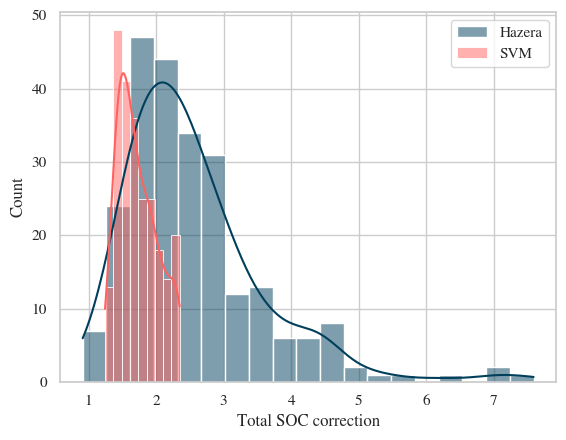

In [87]:
# plotting only the correction and not the corrected values!
sns.histplot(data=all, x=all['Corrected_TOC_Hazera_with_PDOM_TIC'] - all['TOC_istep'], kde=True, label='Hazera')
sns.histplot(data=all, x=all['Corrected_TOC_SVM'] - all['TOC_istep'], kde=True, label = 'SVM')
plt.legend()
plt.xlabel('Total SOC correction')

Text(0.5, 0, 'Total SIC correction')

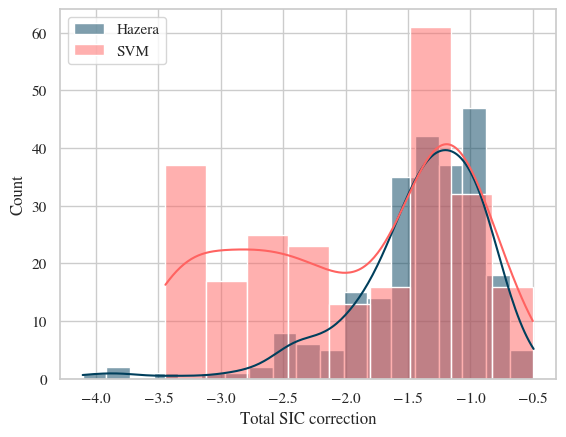

In [88]:
sns.histplot(data=all, x=all['Corrected_TIC_Hazera_with_PDOM_TIC'] - all['TIC_istep'], kde=True, label='Hazera')
sns.histplot(data=all, x=all['Corrected_TIC_SVM'] - all['TIC_istep'], kde=True, label = 'SVM')
plt.legend()
plt.xlabel('Total SIC correction')

## Corrections with new carbonated criterium 

Instead of using a threshold on the total MinC, we can instead use a threshold on the MinC released during oxidation (OxiMINC). If this is < 1g/kg, we consider that the sample containes no inorganic carbon.

We conclude that there is no significant difference when using either one of the thresholds.

Similarly, we can correct using Hazera's correction for soils with Poorly Degraded Organic Matter (PDOM), or without. 
The correction without PDOM works better for our data, yet it is still consistently sub-optimal when compared to the proposed SVM correction. 

In this section, you can set the two parameters `noncarbonated_target` and `topsoil` of the function `hazera_correction` to test the different types of corrections that can be derived from the Hazera et al. paper. 

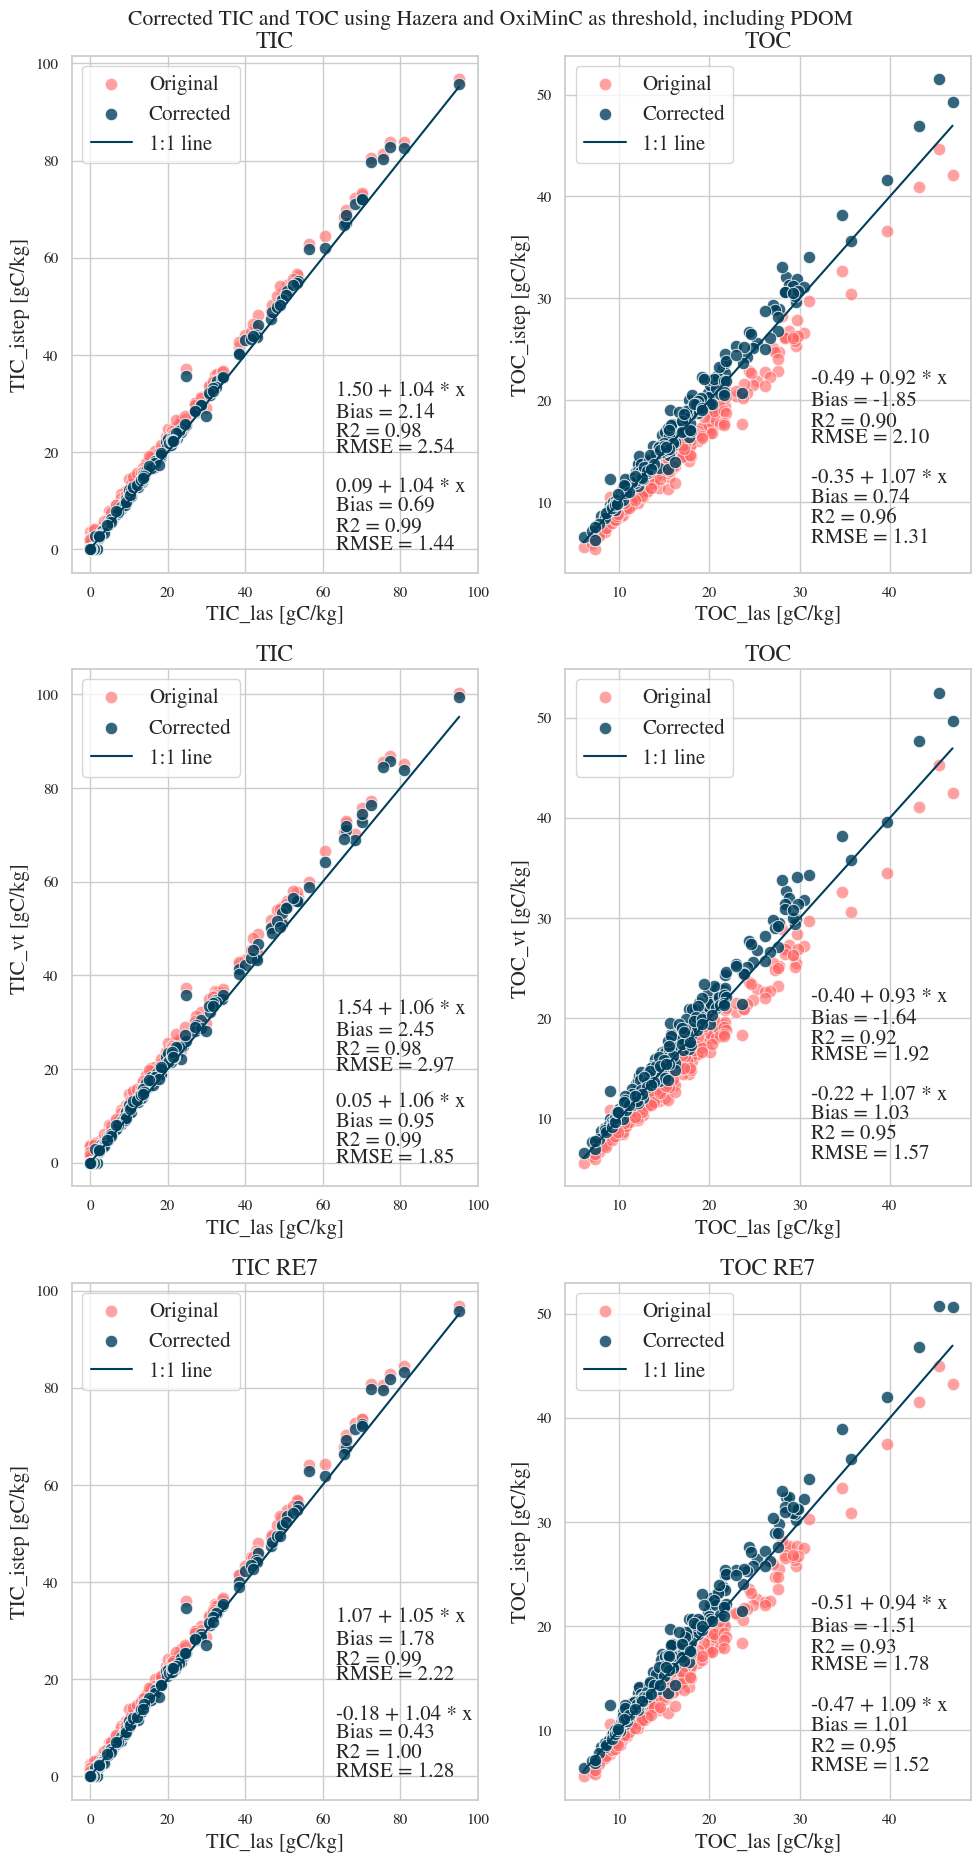

In [36]:
re6_origin='istep'
chn_origin='las'
model_name = 'Hazera'
features='selected'
noncarbonated_threshold_Hazera = 2
data_type = '_' + only_carbonated*'only_carbonated' + only_noncarbonated*'only_noncarbonated'

all_vt = all.loc[:,(~all.columns.str.contains('_istep', case=False)&(~all.columns.str.contains('_re7', case=False)))].copy()
all_istep = all.loc[:,(~all.columns.str.contains('_re7', case=False)&(~all.columns.str.contains('_vt', case=False)))].copy()
all_re7 = all.loc[:,(~all.columns.str.contains('_istep', case=False)&(~all.columns.str.contains('_vt', case=False)))].copy()


all_istep = hazera_correction(all_istep, 'istep', noncarbonated_targed='oxiMinX')
all_vt = hazera_correction(all_vt, 'vt', noncarbonated_targed='oxiMinX')
all_re7 = hazera_correction(all_re7, 're7', noncarbonated_targed='oxiMinX')

plt.subplots(3, 2, figsize=(10,19))
plt.suptitle('Corrected TIC and TOC using Hazera and OxiMinC as threshold, including PDOM')
# LAS ISTEP
plt.subplot(3,2,1)
y_chn_las_istep = all_istep['TIC_las']
y_re_las_istep = all_istep['TIC_istep']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_las_istep, y=y_re_las_istep, correction=all_istep['tic_correction_Hazera_istep'], xlabel='TIC_las', ylabel='TIC_istep', name='TIC')
plt.grid()

plt.subplot(3,2,2)
y_chn_las_istep = all_istep['TOC_las']
y_re_las_istep = all_istep['TOC_istep']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_las_istep, y=y_re_las_istep, correction=all_istep['toc_correction_Hazera_istep'], xlabel='TOC_las', ylabel='TOC_istep', name='TOC')
plt.grid()

# LAS vt
plt.subplot(3,2,3)
y_chn_las_vt = all_vt['TIC'+'_las']
y_re_las_vt = all_vt['TIC_vt']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_las_vt, y=y_re_las_vt, correction=all_vt['tic_correction_Hazera_vt'], xlabel='TIC_las', ylabel='TIC_vt', name='TIC')
plt.grid()

plt.subplot(3,2,4)
y_chn_las_vt = all_vt['TOC'+'_las']
y_re_las_vt = all_vt['TOC_vt']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_las_vt, y=y_re_las_vt, correction=all_vt['toc_correction_Hazera_vt'], xlabel='TOC_las', ylabel='TOC_vt', name='TOC')
plt.grid()

# RE7
plt.subplot(3,2,5)
y_chn_re7_las_istep = all_re7['TIC'+'_las']
y_re_re7_las_istep = all_re7['TIC_re7']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_re7_las_istep, y=y_re_re7_las_istep, correction=all_re7['tic_correction_Hazera_re7'], xlabel='TIC_las', ylabel='TIC_istep', name='TIC RE7')
plt.grid()

plt.subplot(3,2,6)
y_chn_re7_las_istep = all_re7['TOC'+'_las']
y_re_re7_las_istep = all_re7['TOC_re7']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_re7_las_istep.astype(float), y=y_re_re7_las_istep.astype(float), correction=all_re7['toc_correction_Hazera_re7'], xlabel='TOC_las', ylabel='TOC_istep', name='TOC RE7')
plt.grid()

plt.tight_layout()
plt.savefig('output/corrections/'+model_name+'/'+chn_origin + '_' + re6_origin + '_features=' + str(features)+  data_type + '_oxiMINC.png', bbox_inches='tight')


In [27]:
all = hazera_correction(data=all, re6_source='istep', noncarbonated_targed='TIC', topsoil=False)    
all['tic_correction_Hazera_istep'] = all['tic_correction_Hazera_istep'] + all['TIC_istep']
all['toc_correction_Hazera_istep'] = all['toc_correction_Hazera_istep'] + all['TOC_istep']
all.rename(columns={'tic_correction_Hazera_istep' : 'Corrected_TIC_Hazera_without_PDOM_TIC', 'toc_correction_Hazera_istep' : 'Corrected_TOC_Hazera_without_PDOM_TIC'}, inplace=True)


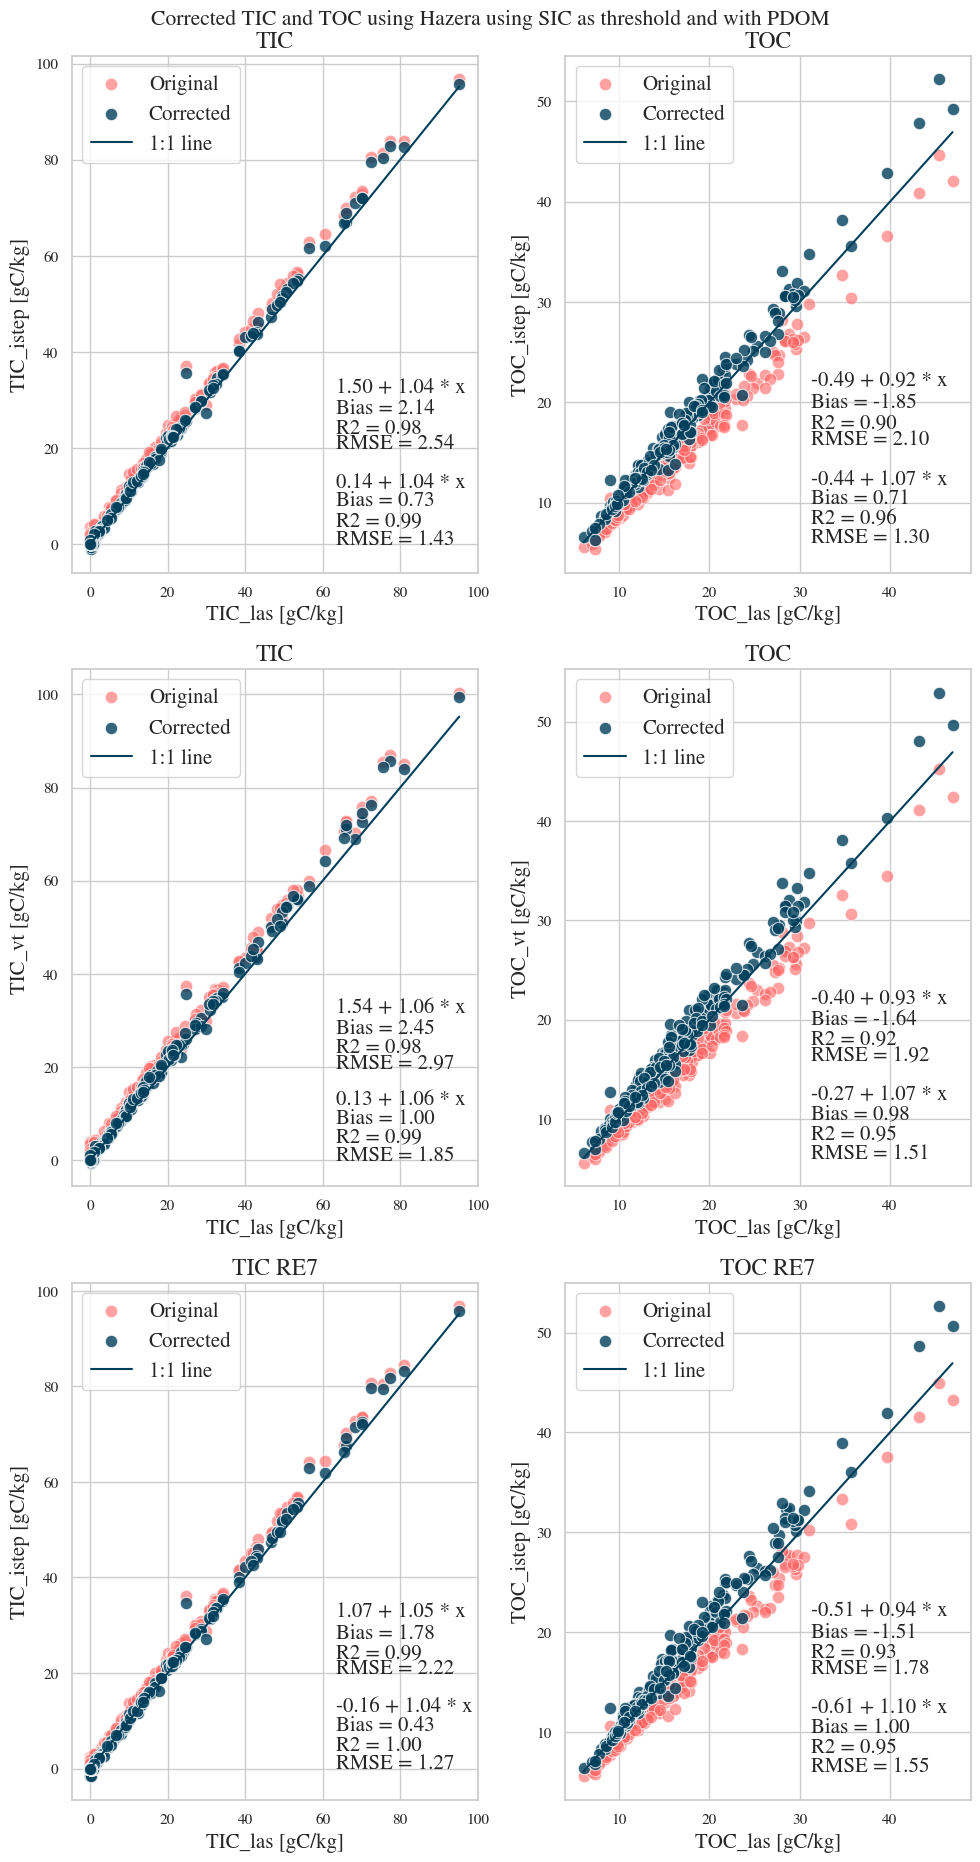

In [37]:
re6_origin='istep'
chn_origin='las'
model_name = 'Hazera'
features='selected'
noncarbonated_threshold_Hazera = 2
data_type = '_' + only_carbonated*'only_carbonated' + only_noncarbonated*'only_noncarbonated'

all_vt = all.loc[:,(~all.columns.str.contains('_istep', case=False)&(~all.columns.str.contains('_re7', case=False)))].copy()
all_istep = all.loc[:,(~all.columns.str.contains('_re7', case=False)&(~all.columns.str.contains('_vt', case=False)))].copy()
all_re7 = all.loc[:,(~all.columns.str.contains('_istep', case=False)&(~all.columns.str.contains('_vt', case=False)))].copy()


all_istep = hazera_correction(all_istep, 'istep', noncarbonated_targed='TIC')
all_vt = hazera_correction(all_vt, 'vt', noncarbonated_targed='TIC')
all_re7 = hazera_correction(all_re7, 're7', noncarbonated_targed='TIC')

plt.subplots(3, 2, figsize=(10,19))
plt.suptitle('Corrected TIC and TOC using Hazera using SIC as threshold and with PDOM')
# LAS ISTEP
plt.subplot(3,2,1)
y_chn_las_istep = all_istep['TIC_las']
y_re_las_istep = all_istep['TIC_istep']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_las_istep, y=y_re_las_istep, correction=all_istep['tic_correction_Hazera_istep'], xlabel='TIC_las', ylabel='TIC_istep', name='TIC')
plt.grid()

plt.subplot(3,2,2)
y_chn_las_istep = all_istep['TOC_las']
y_re_las_istep = all_istep['TOC_istep']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_las_istep, y=y_re_las_istep, correction=all_istep['toc_correction_Hazera_istep'], xlabel='TOC_las', ylabel='TOC_istep', name='TOC')
plt.grid()

# LAS vt
plt.subplot(3,2,3)
y_chn_las_vt = all_vt['TIC'+'_las']
y_re_las_vt = all_vt['TIC_vt']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_las_vt, y=y_re_las_vt, correction=all_vt['tic_correction_Hazera_vt'], xlabel='TIC_las', ylabel='TIC_vt', name='TIC')
plt.grid()

plt.subplot(3,2,4)
y_chn_las_vt = all_vt['TOC'+'_las']
y_re_las_vt = all_vt['TOC_vt']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_las_vt, y=y_re_las_vt, correction=all_vt['toc_correction_Hazera_vt'], xlabel='TOC_las', ylabel='TOC_vt', name='TOC')
plt.grid()

# RE7
plt.subplot(3,2,5)
y_chn_re7_las_istep = all_re7['TIC'+'_las']
y_re_re7_las_istep = all_re7['TIC_re7']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_re7_las_istep, y=y_re_re7_las_istep, correction=all_re7['tic_correction_Hazera_re7'], xlabel='TIC_las', ylabel='TIC_istep', name='TIC RE7')
plt.grid()

plt.subplot(3,2,6)
y_chn_re7_las_istep = all_re7['TOC'+'_las']
y_re_re7_las_istep = all_re7['TOC_re7']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_re7_las_istep.astype(float), y=y_re_re7_las_istep.astype(float), correction=all_re7['toc_correction_Hazera_re7'], xlabel='TOC_las', ylabel='TOC_istep', name='TOC RE7')
plt.grid()

plt.tight_layout()
plt.savefig('output/corrections/'+model_name+'/'+chn_origin + '_' + re6_origin + '_features=' + str(features)+  data_type + '.png', bbox_inches='tight')


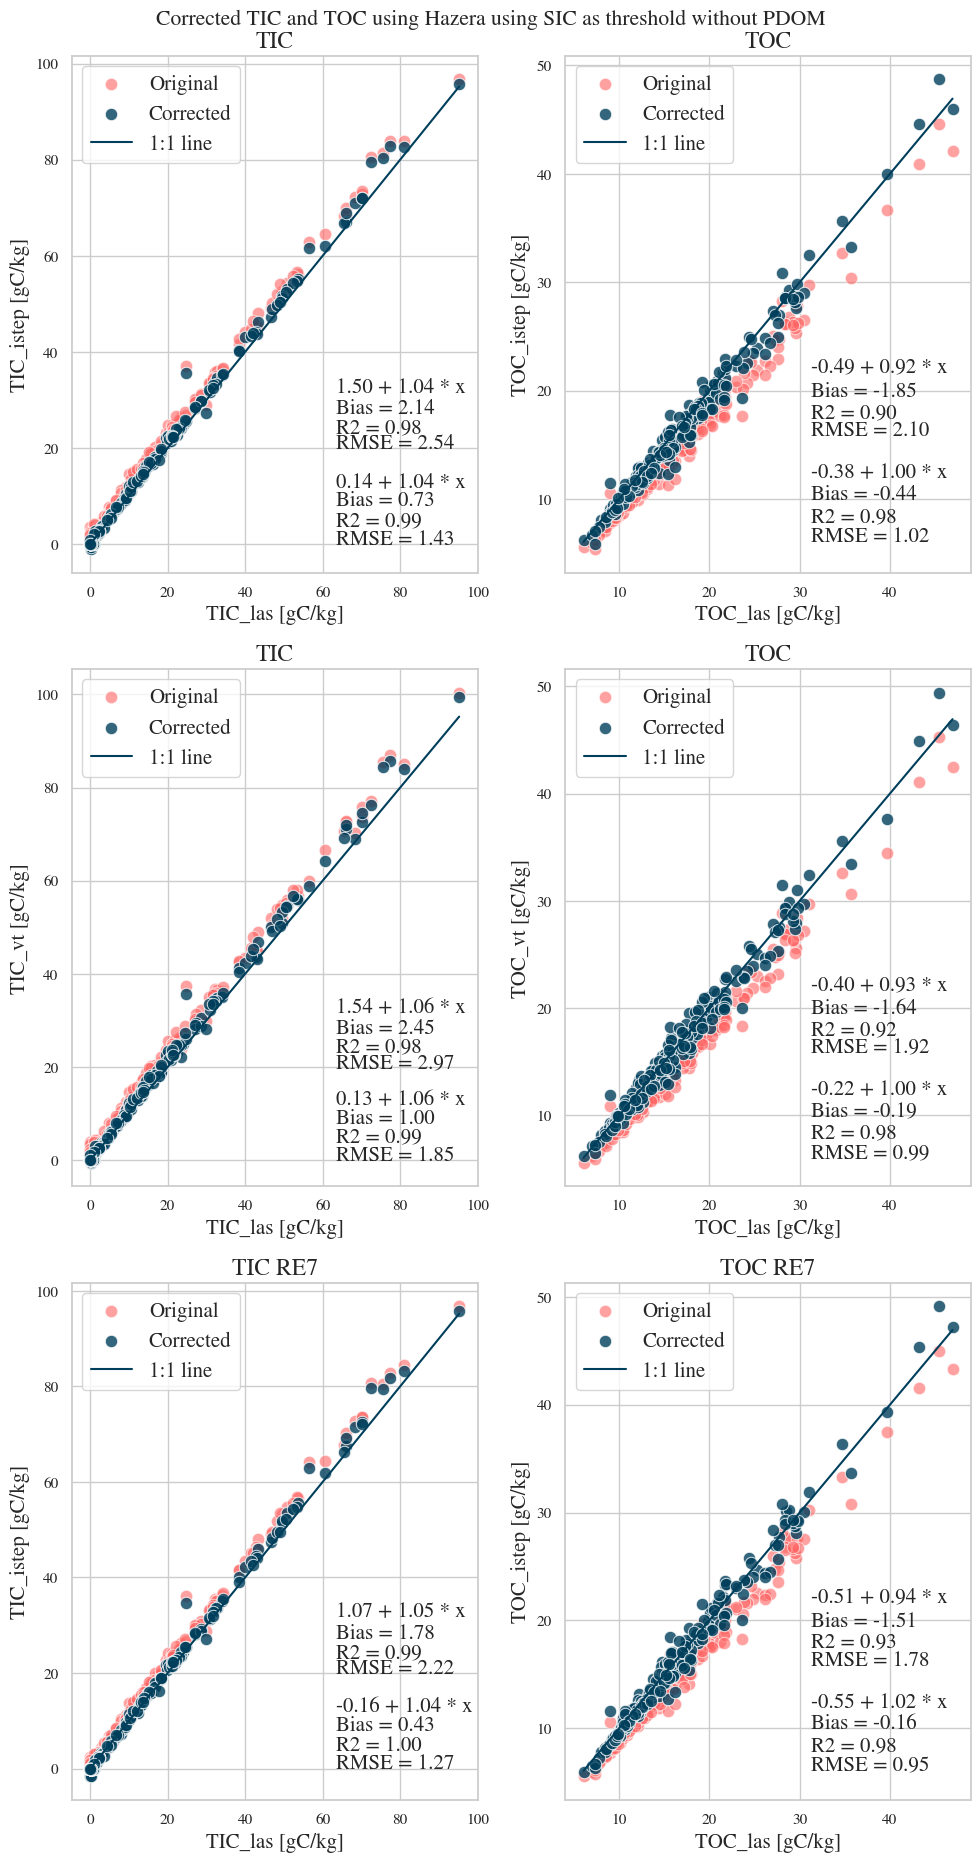

In [38]:
re6_origin='istep'
chn_origin='las'
model_name = 'Hazera'
features='selected'
noncarbonated_threshold_Hazera = 2
data_type = '_' + only_carbonated*'only_carbonated' + only_noncarbonated*'only_noncarbonated'

all_vt = all.loc[:,(~all.columns.str.contains('_istep', case=False)&(~all.columns.str.contains('_re7', case=False)))].copy()
all_istep = all.loc[:,(~all.columns.str.contains('_re7', case=False)&(~all.columns.str.contains('_vt', case=False)))].copy()
all_re7 = all.loc[:,(~all.columns.str.contains('_istep', case=False)&(~all.columns.str.contains('_vt', case=False)))].copy()


all_istep = hazera_correction(all_istep, 'istep', noncarbonated_targed='TIC', topsoil=False)
all_vt = hazera_correction(all_vt, 'vt', noncarbonated_targed='TIC', topsoil=False)
all_re7 = hazera_correction(all_re7, 're7', noncarbonated_targed='TIC', topsoil=False)

plt.subplots(3, 2, figsize=(10,19))
plt.suptitle('Corrected TIC and TOC using Hazera using SIC as threshold without PDOM')
# LAS ISTEP
plt.subplot(3,2,1)
y_chn_las_istep = all_istep['TIC_las']
y_re_las_istep = all_istep['TIC_istep']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_las_istep, y=y_re_las_istep, correction=all_istep['tic_correction_Hazera_istep'], xlabel='TIC_las', ylabel='TIC_istep', name='TIC')
plt.grid()

plt.subplot(3,2,2)
y_chn_las_istep = all_istep['TOC_las']
y_re_las_istep = all_istep['TOC_istep']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_las_istep, y=y_re_las_istep, correction=all_istep['toc_correction_Hazera_istep'], xlabel='TOC_las', ylabel='TOC_istep', name='TOC')
plt.grid()

# LAS vt
plt.subplot(3,2,3)
y_chn_las_vt = all_vt['TIC'+'_las']
y_re_las_vt = all_vt['TIC_vt']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_las_vt, y=y_re_las_vt, correction=all_vt['tic_correction_Hazera_vt'], xlabel='TIC_las', ylabel='TIC_vt', name='TIC')
plt.grid()

plt.subplot(3,2,4)
y_chn_las_vt = all_vt['TOC'+'_las']
y_re_las_vt = all_vt['TOC_vt']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_las_vt, y=y_re_las_vt, correction=all_vt['toc_correction_Hazera_vt'], xlabel='TOC_las', ylabel='TOC_vt', name='TOC')
plt.grid()

# RE7
plt.subplot(3,2,5)
y_chn_re7_las_istep = all_re7['TIC'+'_las']
y_re_re7_las_istep = all_re7['TIC_re7']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_re7_las_istep, y=y_re_re7_las_istep, correction=all_re7['tic_correction_Hazera_re7'], xlabel='TIC_las', ylabel='TIC_istep', name='TIC RE7')
plt.grid()

plt.subplot(3,2,6)
y_chn_re7_las_istep = all_re7['TOC'+'_las']
y_re_re7_las_istep = all_re7['TOC_re7']
r2, bias, rmse, rpiq, slope, intercept, r2_corrected, bias_corrected, rmse_corrected, rpiq_corrected, intercept_corrected, slope_corrected = scatterplot_correction(x=y_chn_re7_las_istep.astype(float), y=y_re_re7_las_istep.astype(float), correction=all_re7['toc_correction_Hazera_re7'], xlabel='TOC_las', ylabel='TOC_istep', name='TOC RE7')
plt.grid()

plt.tight_layout()
plt.savefig('output/corrections/'+model_name+'/'+chn_origin + '_' + re6_origin + '_features=' + str(features)+  data_type + 'without_poorlyDegradedOrgComp.png', bbox_inches='tight')


## Testing the impact of the learning set size

In [128]:
re6_origin='istep'
chn_origin='las'
model_name = 'SVM'
features='selected'
features_tic = ['TIC_'+re6_origin]
features_toc = ['TOC_'+re6_origin]

report=[]
report_columns = [
    'Model',
    'Target',
    'CHN_origin',
    'RE_origin',
    'Features',
    'CHN_target',
    'RE_target',
    'R2',
    'Bias',
    'RMSE',
    'RPIQ,',
    'Slope',
    'Intercept',
    'R2_corrected',
    'Bias_corrected',
    'RMSE_corrected',
    'RPIQ_corrected',
    'Slope_corrected',
    'Intercept_corrected',
]

set_size_report = pd.DataFrame(columns=report_columns)

In [133]:
for rep in range(50):
    for set_size in np.linspace(0.1, 1, 10):
        report=[]
        report, regressor_toc, regressor_tic, train_index, test_index = run_full_model(data=all.sample(frac=set_size, replace=False, random_state=np.random.randint(0,100000)).reset_index(),
                                                                                    re6_predictors=re6_predictors,
                                                                                    re6_origin=re6_origin, 
                                                                                    chn_origin=chn_origin, 
                                                                                    model_name=model_name, 
                                                                                    features=features, 
                                                                                    features_tic=features_tic,
                                                                                    features_toc=features_toc,
                                                                                    report=report, 
                                                                                    only_carbonated=only_carbonated, 
                                                                                    only_noncarbonated=only_noncarbonated)
        plt.close()
        temp_report = pd.DataFrame(report, columns=report_columns)
        temp_report['Set_size'] = 160*set_size
        set_size_report = pd.concat([set_size_report, temp_report])

In [134]:
tic_report = set_size_report[(set_size_report['Target'] == 'TIC') & (set_size_report['CHN_target'] == 'las') & (set_size_report['RE_target'] == 'istep')]
toc_report = set_size_report[(set_size_report['Target'] == 'TOC') & (set_size_report['CHN_target'] == 'las') & (set_size_report['RE_target'] == 'istep')]

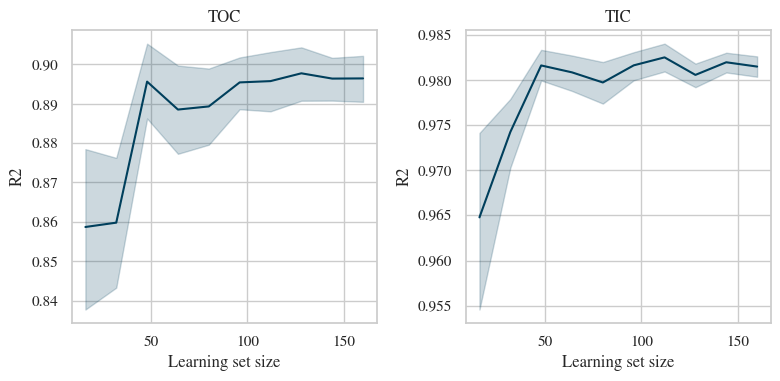

In [138]:
plt.subplots(1,2,figsize=(8,4))
plt.subplot(1,2,1)
sns.lineplot(data=toc_report, x='Set_size', y='R2')
plt.xlabel('Learning set size')
plt.title('TOC')
plt.subplot(1,2,2)
sns.lineplot(data=tic_report, x='Set_size', y='R2')
plt.xlabel('Learning set size')
plt.title('TIC')
plt.tight_layout()
